In [11]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [12]:
sys.path.append("../")

import bfcnn
from bfcnn import custom_layers

In [13]:
# run params
SECTION = "test"
RUN_ID = "0001"
BASE_DIR= "./run"
DATA_NAME = "cifar10"
BASE_DIR_SECTION = "{0}/{1}/".format(BASE_DIR, SECTION)
RUN_FOLDER = BASE_DIR_SECTION + "_".join([RUN_ID, DATA_NAME])

if not os.path.exists(BASE_DIR):
    os.mkdir(BASE_DIR)

if not os.path.exists(BASE_DIR_SECTION):
    os.mkdir(BASE_DIR_SECTION)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, "viz"))
    os.mkdir(os.path.join(RUN_FOLDER, "images"))
    os.mkdir(os.path.join(RUN_FOLDER, "weights"))

In [14]:
# model / data parameters
num_classes = 10
input_shape = (32, 32, 3)

# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
# convert class vectors to binary class matrices
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

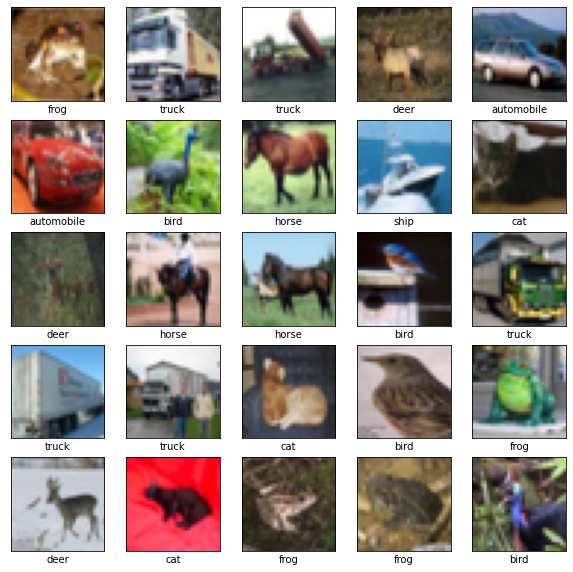

In [15]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [16]:
batch_size = 64
epochs = 20

In [17]:
model_base = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.BatchNormalization(center=False, scale=True),
        keras.layers.Conv2D(filters=32,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="relu"),
        keras.layers.Conv2D(filters=64,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="relu"),
        keras.layers.Conv2D(filters=64,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="relu"),
        keras.layers.BatchNormalization(center=False, scale=True),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, use_bias=False, activation="relu", kernel_regularizer="l1"),
        keras.layers.Dense(num_classes, use_bias=False, activation="linear", kernel_regularizer="l1"),
    ]
)

model_base.summary()

model_base.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"])

history = \
    model_base.fit(
        x_train - 0.5,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 32, 32, 3)        9         
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        2400      
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          51200     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          102400    
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 64)         192       
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

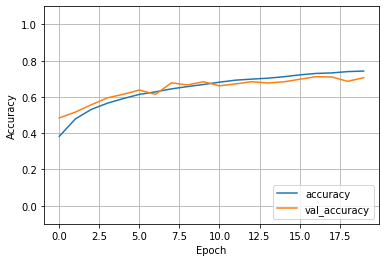

In [18]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.legend(loc="lower right")

In [19]:
model_gate = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.BatchNormalization(center=False, scale=True),
        keras.layers.Conv2D(filters=32,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="linear"),
        bfcnn.custom_layers.DifferentiableGateLayer(regularizer="l1"),
        keras.layers.Conv2D(filters=64,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="linear"),
        bfcnn.custom_layers.DifferentiableGateLayer(regularizer="l1"),
        keras.layers.Conv2D(filters=64,
                            padding="same",
                            strides=(2, 2),
                            use_bias=False,
                            kernel_size=(5, 5),
                            activation="linear"),
        bfcnn.custom_layers.DifferentiableGateLayer(regularizer="l1"),
        keras.layers.BatchNormalization(center=False, scale=True),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, use_bias=False, activation="linear", kernel_regularizer="l1"),
        bfcnn.custom_layers.DifferentiableGateLayer(regularizer="l1"),
        keras.layers.Dense(num_classes, use_bias=False, activation="linear", kernel_regularizer="l1"),
    ]
)

model_gate.summary()

model_gate.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"])

history = \
    model_gate.fit(
        x_train - 0.5,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 32, 32, 3)        9         
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        2400      
                                                                 
 differentiable_gate_layer_4  (None, 16, 16, 32)       2         
  (DifferentiableGateLayer)                                      
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          51200     
                                                                 
 differentiable_gate_layer_5  (None, 8, 8, 64)         2         
  (DifferentiableGateLayer)                                      
                                                      

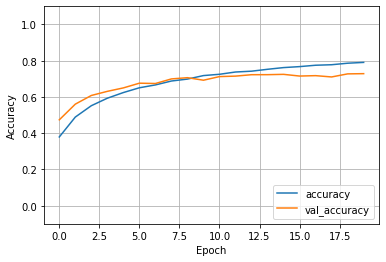

In [20]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.1])
plt.grid(True)
plt.legend(loc="lower right")
